In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
use_existing_client='tcp://127.0.0.1:36629'

/home/a/a270042/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
# input_paths.append('/work/ab0995/a270062/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/Greensplit/outdata/fesom')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl       = None
do_allcycl   = False
vname        = 'amoc'
year         = [1958,2019]
mon          = None
day          = None
record       = None 
box          = None
depth        = None
dlat         = 1.0   # binning resolution in deg 
do_bolus     = False
which_transf = 'dmoc'
do_zcoord    = False
which_lat    = 26.5 # 'max' # 'max', 26.0

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
# from where provide zinfo for projection to zcoord, options: 'std_dens_H'(Best), 'hydrography'(OK), 
# 'density_dMOC'(Bad), 'std_dens_Z'(Very Bad)
do_useZinfo       = 'std_dens_H' #from where provide zinfo for projection to zcoord, options: 'std_dens_H', 'density_dMOC', 'std_dens_Z'
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
do_enum           = False  # do enumeration of panels
save_dpi          = 300
save_fmt          = ['png']
#do_rapid          = False

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
do_ucell          = True   # do time series of upper amoc cell 
do_lcell          = False  # do time series of lower amoc cell 

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem, 
                                       threads_per_worker=parallel_nthread)

Connected to existing Dask cluster: <Client: 'tcp://127.0.0.1:36629' processes=32 threads=64, memory=214.58 GiB>


<Client: 'tcp://127.0.0.1:36629' processes=32 threads=64, memory=214.58 GiB>

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, _, _ = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

# #______________________________________________________________________________________________________        
# cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path != None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record    
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
#     ref_cinfo['cref']=0.0

# #______________________________________________________________________________________________________    
# # concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
# input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])          
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

#______________________________________________________________________________________________________            
# define density levels 
# !!! ATTENTION: !!!
# use here the density MOC levels that are specfic for your run. They might be different from the one im 
# using here since they might need to be customized specific to your hydrography to be able to cover the 
# whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

# original dima
std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# # my density layers 2nd try
# std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
#           32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
#           33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
#           34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
#           35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
#           35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
#           36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
#           36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
#           37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 1    , #put here the time res. of you file if not daily  
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto', 
               'ndens': len(std_dens), 
               'edg_n': 'auto'}) 

if client is not None:
    # set size limit of horizontal chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.05
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 
    if   chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']
    if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    if   chunks['ndens']!= 'auto': chunk_size = chunk_size/chunks['ndens']
    chunks['elem'] = chunks['nod2'] = np.int32(np.ceil(chunk_size))
    print(' --> set elem/nod2 chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['elem']))

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________
 --> worker memory      : 6866.46Mb
 --> limit chunksize to : 343.32Mb
 --> set elem/nod2 chunk size to 5.00% of worker mem.: 1011236


In [5]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
zdefuc,zdeflc = [200,3000], [800, 6000]     #zlevel definition for upper/lower cell
ddefuc,ddeflc = [36.0, 36.80], [36.0, 37.8] #density class definition for upper/lower cell

data_list     = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 2  # compute dmoc time-series in chunks of chnk_size years 
                   #-> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    print(' > year:', end='')
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        ts = clock.time()
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='')
         
        #____________________________________________________________________________________________________
        # load DMOC std_* data --> combined in xarray dataset
        data = tpv.load_dmoc_data(mesh, datapath, std_dens, year=year_chnk, which_transf=which_transf, do_info=False, 
                                  do_tarithm=None, do_zcoord=do_zcoord, do_useZinfo=do_useZinfo, descript=descript, 
                                  do_bolus=do_bolus, add_bolus=True, do_load=False, do_persist=False, do_parallel=do_parallel )
        
        # check if data where loaded
        if data is None: 
            print(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
            continue
    
        #____________________________________________________________________________________________________
        # compute moc profile over time
        # dmoc      = tpv.calc_dmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_load=True,
        #                           do_parallel=do_parallel, n_workers=128-parallel_nprc)
        dmoc     = tpv.calc_dmoc_dask(mesh, data, do_parallel, parallel_nprc, dlat=dlat, which_moc=vname, 
                                  which_transf=which_transf, do_info=False, do_checkbasin=False, 
                                  do_exclude=True, #exclude mediterranean and black sea from gmoc
                                  exclude_list=list(['ocean_basins/Mediterranean_Basin.shp', [26,42,39.5,47]]))   
        
        #____________________________________________________________________________________________________
        # compute time-series
        # --> if the correct information for density class z position is available define upper lower cell 
        # by depth criteria zdefuc,zdeflc
        if 'ndens_zfh' in list(dmoc.keys()):
            if  vname == 'ipmoc' or vname == 'pmoc':
                dmoc_tchnk = dmoc.where((dmoc['ndens_zfh']>=zdeflc[0]) & (dmoc['ndens_zfh']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
            elif vname == 'amoc' or vname == 'aamoc':
                dmoc_nadw  = dmoc.where((dmoc['ndens_zfh']>=zdefuc[0]) & (dmoc['ndens_zfh']<=zdefuc[1])).max(dim='ndens',skipna=True).rename({'dmoc':'dmoc_nadw'})
                dmoc_aabw  = dmoc.where((dmoc['ndens_zfh']>=zdeflc[0]) & (dmoc['ndens_zfh']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
                dmoc_tchnk = xr.merge([dmoc_nadw,dmoc_aabw], compat='minimal' )
                del(dmoc_aabw, dmoc_nadw)
        # --> if there is no correct information for density class z position define upper lower cell 
        # by density criteria ddefuc,ddeflc
        else:
            if  vname == 'ipmoc' or vname == 'pmoc':
                dmoc_tchnk = dmoc.where((dmoc['ndens']>=ddeflc[0]) & (dmoc['ndens']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
            elif vname == 'amoc' or vname == 'aamoc':
                dmoc_nadw  = dmoc.where((dmoc['ndens']>=ddefuc[0]) & (dmoc['ndens']<=zdefuc[1])).max(dim='ndens',skipna=True).rename({'dmoc':'dmoc_nadw'})
                dmoc_aabw  = dmoc.where((dmoc['ndens']>=ddeflc[0]) & (dmoc['ndens']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
                dmoc_tchnk = xr.merge([dmoc_nadw,dmoc_aabw], compat='minimal' )
                del(dmoc_aabw, dmoc_nadw)
        if nchnk==0: dmoc_t = dmoc_tchnk
        else       : dmoc_t = xr.concat([dmoc_t, dmoc_tchnk], dim='time')
        
        #____________________________________________________________________________________________________
        del(data, dmoc, dmoc_tchnk)
        print(' --> elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0), end='\n        ')   
        if client is not None: client.run(gc.collect)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    data_list.append(dmoc_t)    
    del(dmoc_t)
print('\n --> total elasped time tp process data: {:3.2f} min.'.format( (clock.time()-t0)/60  ))     

/work/ab0995/a270062/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/Greensplit/outdata/fesom Tido Test
 > year:1950|1951

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/distributed/worker.py:3039: UserWarning: Large object of size 47.78 MiB detected in task graph: 
  ("('truediv-7676d9b4cffe1745b5241bd052bec890', 0,  ... , None, None)))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


 --> rechunk: 10 -> 64 --> elapsed time: 2.12min.
        1952|1953 --> rechunk: 10 -> 64 --> elapsed time: 2.10min.
        1954|1955 --> rechunk: 10 -> 64 --> elapsed time: 2.02min.
        1956|1957 --> rechunk: 10 -> 64 --> elapsed time: 2.10min.
        1958|1959 --> rechunk: 10 -> 64 --> elapsed time: 2.04min.
        1960|1961 --> rechunk: 10 -> 64 --> elapsed time: 2.07min.
        1962|1963 --> rechunk: 10 -> 64 --> elapsed time: 2.09min.
        1964|1965 --> rechunk: 10 -> 64 --> elapsed time: 2.10min.
        1966|1967 --> rechunk: 10 -> 64 --> elapsed time: 2.10min.
        1968|1969 --> rechunk: 10 -> 64 --> elapsed time: 2.09min.
        1970|1971 --> rechunk: 10 -> 64 --> elapsed time: 2.12min.
        1972|1973 --> rechunk: 10 -> 64 --> elapsed time: 2.09min.
        1974|1975 --> rechunk: 10 -> 64 --> elapsed time: 2.10min.
        1976|1977 --> rechunk: 10 -> 64 --> elapsed time: 2.12min.
        1978|1979 --> rechunk: 10 -> 64 --> elapsed time: 2.18min.
        
 --

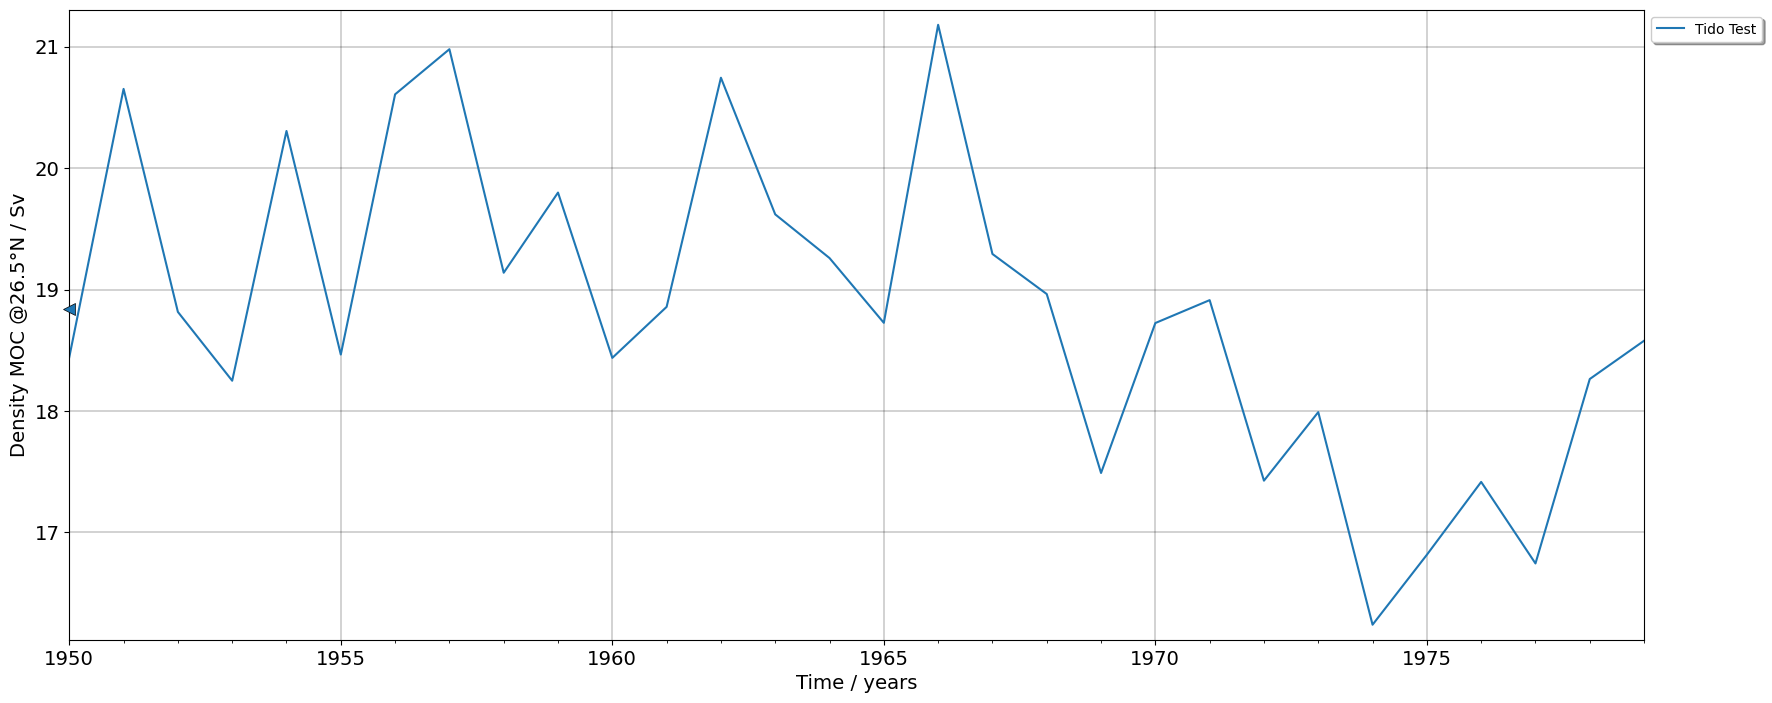

In [6]:
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
if do_ucell:
    for lat in which_lat: 
        lat_list = list()
        for data in data_list:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['dmoc_nadw','dmoc_ucell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                        str_label= f'@{40}°N<lat<{60}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    lat_list.append([data_lat])        

        #___PLOT TRANSECT__________________________________________________________________________________
        svname = list(lat_list[0][0].data_vars)[0]
        slabel = lat_list[0][0][svname].attrs['str_lsave']
        stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
        #__________________________________________________________________________________________________
        # do save filename path
        spath  = save_path
        sfpath = None
        if spath!=None: 
            sfpath=list()
            for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'dmoc_t_ucell', stname ,slabel, sfmt)) )
        if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
        
        #__________________________________________________________________________________________________
        fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                                n_cycl     = n_cycl                  , 
                                do_allcycl = do_allcycl              , 
                                do_concat  = do_concat               , 
                                do_shdw    = do_shdw                 ,
                                do_mean    = do_mean                 ,
                                do_std     = do_std                  ,
                                ax_opt     = dict({'fig_sizefac':4}) ,
                                do_enum    = do_enum                 ,
                                do_save    = sfpath, save_dpi=save_dpi, 
                             )            

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
if do_lcell:
    for lat in which_lat: 
        lat_list = list()
        for data in data_list:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['dmoc_aabw','dmoc_lcell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>-20) & (data.lat<60)).min(dim='lat') 
                        str_label= f'@{-20}°S<lat<{60}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    data_lat[var].attrs['short_name'] = 'AABW'
                    data_lat[var].attrs['long_name']  = 'AABW'
                    lat_list.append([data_lat])        

        #___PLOT TRANSECT__________________________________________________________________________________
        svname = list(lat_list[0][0].data_vars)[0]
        slabel = lat_list[0][0][svname].attrs['str_lsave']
        stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
        #__________________________________________________________________________________________________
        # do save filename path
        spath  = save_path
        sfpath = None
        if spath!=None: 
            sfpath=list()
            for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'dmoc_t_lcell', stname ,slabel, sfmt)) )
        if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
        
        #__________________________________________________________________________________________________
        fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                                n_cycl     = n_cycl                  , 
                                do_allcycl = do_allcycl              , 
                                do_concat  = do_concat               , 
                                do_shdw    = do_shdw                 ,
                                do_mean    = do_mean                 ,
                                do_std     = do_std                  ,
                                ax_opt     = dict({'fig_sizefac':4}) ,
                                grid_opt   = dict({'do_yinvert':True}),
                                do_enum    = do_enum                  ,
                                do_save    = sfpath, save_dpi=save_dpi, 
                             )

In [7]:
if do_papermill and do_parallel and client is not None: client.shutdown()